In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import math
from functools import partial
from typing import Iterable, Callable, Optional
from numbers import Number

## Define prediction class

In [2]:
class PredictionTask:
    def __init__(self, input, outcome=None):
        self.A = input
        self.B = outcome


class WeightedPredictionClass:
    def __init__(self, tasks: Iterable[PredictionTask], weights: Optional[Iterable[Number]] = None):
        self.tasks = tasks
        for task in self.tasks:
            if task.B is None:
                raise ValueError("All WeightedPredictionClass task outcomes must be known.")
        J = len(tasks)
        if weights is not None:
            if len(weights) != J:
                raise ValueError(f"len(weights), {len(weights)}, must equal len(tasks), {J}")
            self.weights = np.array(weights) / sum(weights)
        else:
            self.weights = np.ones(J)/J

    def predictive_success(self, predicted_log_likelihood: Callable[[PredictionTask], float]) -> float:
        return sum(w * predicted_log_likelihood(task) 
                   for w, task in zip(self.weights, self.tasks)
                   if task.B is not None)

In [3]:
def generate_x(x_range, step=0.1, copies=20):
    x_values = np.round(np.arange(x_range[0], x_range[1] + step, step), decimals=1)
    repeated_x_values = np.tile(x_values, copies)
    return np.sort(repeated_x_values)


def generate_y(x, noise_std=0.0):
    """Generates data based on the specified model."""
    y = 0.5 + 0.5 * np.tanh(x - 2)
    if noise_std:
        y += np.random.normal(0, noise_std, size=len(x))
    return y

In [4]:
# Set the seed for replicability
seed = sum(ord(char) for char in "Rumpelstiltskin")
np.random.seed(seed)

x0 = generate_x((0, 3.5), copies=20)
y_known = generate_y(x0, noise_std=0.05)
df = pd.DataFrame({'x': x0, 'y': y_known})


def make_task(in_range, out_range) -> PredictionTask:
    x_known = df[(df['x'] >= in_range[0]) & (df['x'] <= in_range[1])]['x'].values
    y_known = df[(df['x'] >= in_range[0]) & (df['x'] <= in_range[1])]['y'].values
    x_to_predict = df[(df['x'] >= out_range[0]) & (df['x'] <= out_range[1])]['x'].values
    y_to_predict = df[(df['x'] >= out_range[0]) & (df['x'] <= out_range[1])]['y'].values
    return PredictionTask(
        dict(x_known=x_known,
             y_known=y_known,
             x_to_predict=x_to_predict,
        ),
        y_to_predict,
    )

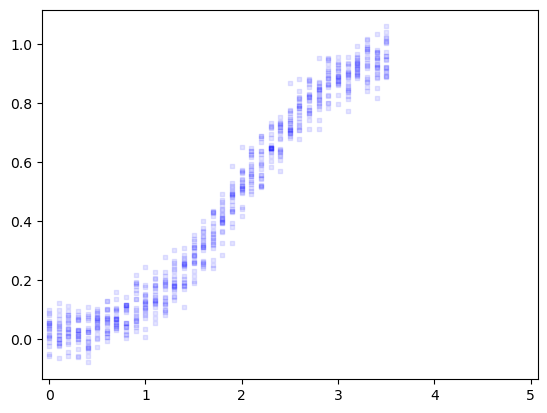

In [5]:
#| label: fig-known-data
#| fig-cap: "Known Data"
task_of_interest = make_task((0, 3.5), (3.6, 5))
plt.scatter(task_of_interest.A['x_known'], task_of_interest.A['y_known'], label="TRUE", 
            color="blue", marker='s', s=10, alpha=0.1)
plt.xlim(-0.075, 5.075)
#plt.ylim(-0.2, 1.2)
plt.show()

In [6]:
pclass_single = WeightedPredictionClass([make_task((0, 2.5), (2.6, 3.5))])

## Define predictive methods

In [7]:
def log_likelihood(y_pred, y, sigma2) -> float:
    """Average log-likelihood"""
    pi = math.pi
    ln = math.log
    MSE = np.mean((y_pred - y)**2)
    return -(1/2)*(ln(2*pi*sigma2) + MSE/sigma2)

statsmodels OLS documentation: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

In [8]:
def predicted_ll(model_name, task: PredictionTask) -> float:
    x = task.A['x_known']
    y = task.A['y_known']
    x_out = task.A['x_to_predict']
    fit_results = sm.OLS(y, design_matrix(model_name, x)).fit()
    y_pred = fit_results.predict(design_matrix(model_name, x_out))
    return log_likelihood(y_pred, task.B, fit_results.mse_resid)


def design_matrix(model_name, x):
    if model_name == "Poly-4":
        X = np.column_stack([np.ones(len(x)), x, x**2, x**3, x**4])
    elif model_name == "Poly-3":
        X = np.column_stack([np.ones(len(x)), x, x**2, x**3])
    elif model_name == "Poly-2":
        X = np.column_stack([np.ones(len(x)), x, x**2])
    elif model_name == "Poly-1":
        X = np.column_stack([np.ones(len(x)), x])
    elif model_name == "Poly-0":
        X = np.column_stack([np.ones(len(x))])
    else:
        raise NotImplementedError(model_name)
    return X


sim_models = ["Poly-0", "Poly-1", "Poly-2", "Poly-3", "Poly-4"]

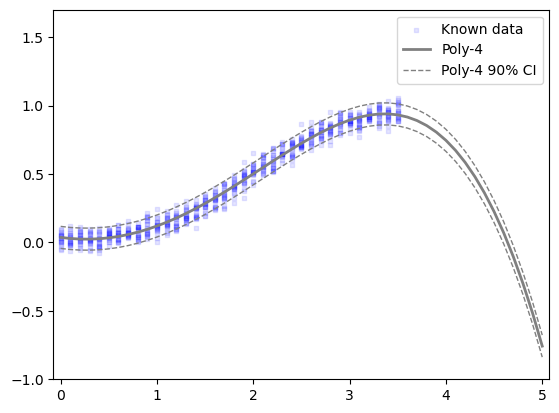

In [9]:
#| label: fig-poly4-predict
#| fig-cap: "POLY-4 Prediction"
x_all = generate_x((0, 5), copies=1)
fit_results4 = sm.OLS(
    task_of_interest.A['y_known'],
    design_matrix("Poly-4", task_of_interest.A['x_known']),
).fit()
y4 = fit_results4.predict(design_matrix("Poly-4", x_all))    
y4_std = fit_results4.mse_resid**0.5
plt.scatter(task_of_interest.A['x_known'], task_of_interest.A['y_known'], 
            label="Known data", color="blue", marker='s', s=10, alpha=0.1)
plt.plot(x_all, y4, label="Poly-4", color="gray", linewidth=2)
plt.plot(x_all, y4 + 1.645*y4_std, label=f"Poly-4 90% CI", color="gray", linestyle='--', linewidth=1)
plt.plot(x_all, y4 - 1.645*y4_std, color="gray", linestyle='--', linewidth=1)
plt.xlim(-0.075, 5.075)
plt.ylim(-1.0, 1.7)
plt.legend()
plt.show()

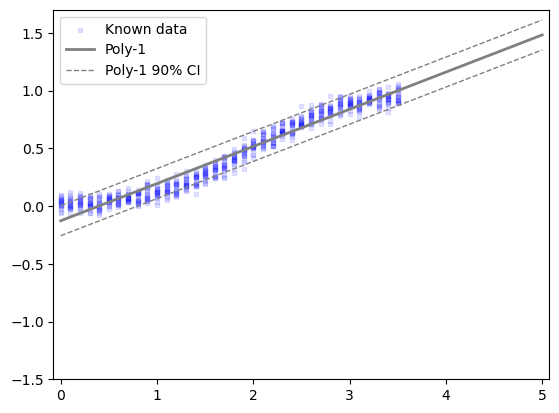

In [10]:
#| label: fig-poly1-predict
#| fig-cap: "POLY-1 Prediction"
fit_results1 = sm.OLS(
    task_of_interest.A['y_known'],
    design_matrix("Poly-1", task_of_interest.A['x_known']),
).fit()
y1 = fit_results1.predict(design_matrix("Poly-1", x_all))
y1_std = fit_results1.mse_resid**0.5
plt.scatter(task_of_interest.A['x_known'], task_of_interest.A['y_known'], 
            label="Known data", color="blue", marker='s', s=10, alpha=0.1)
plt.plot(x_all, y1, label="Poly-1", color="gray", linewidth=2)
plt.plot(x_all, y1 + 1.645*y1_std, label=f"Poly-1 90% CI", color="gray", linestyle='--', linewidth=1)
plt.plot(x_all, y1 - 1.645*y1_std, color="gray", linestyle='--', linewidth=1)
plt.xlim(-0.075, 5.075)
plt.ylim(-1.5, 1.7)
plt.legend()
plt.show()

## Main Results

In [11]:
scores_single = [pclass_single.predictive_success(partial(predicted_ll, model_name)) for model_name in sim_models]
scores_single

[np.float64(-2.870443608400252),
 np.float64(0.8788369626883851),
 np.float64(-18.63054717541598),
 np.float64(-4.984451316175962),
 np.float64(-9.054374407164836)]

In [12]:
[math.exp(ll) for ll in scores_single]

[0.056673780037751864,
 2.4080973700308568,
 8.10692521752496e-09,
 0.006843531932783001,
 0.00011687864225465167]

In [13]:
def plot_predicted_centrality(model_name, task):
    """Plot predicted line (over full 0-3.5 domain) over scatter plot of the _to_predict data"""
    x_all = generate_x((0, 5), copies=1)
    fit_results = sm.OLS(
        task.A['y_known'],
        design_matrix(model_name, task.A['x_known']),
    ).fit()
    y_pred = fit_results.predict(design_matrix(model_name, x_all))
    y_std = fit_results.mse_resid**0.5
    plt.scatter(task.A['x_known'], task.A['y_known'], label="Training Data", 
                color="blue", marker='s', s=10, alpha=0.1)
    plt.scatter(task.A['x_to_predict'], task.B, label="Held-out Data", 
                color="green", marker='s', s=10, alpha=0.1)
    plt.plot(x_all, y_pred, label=model_name, color="gray", linewidth=2)
    plt.plot(x_all, y_pred + 1.645*y_std, label=f"{model_name} 90% CI", color="gray", linestyle='--', linewidth=1)
    plt.plot(x_all, y_pred - 1.645*y_std, color="gray", linestyle='--', linewidth=1)
    plt.xlim(-0.075, 3.575)
    plt.ylim(-0.1, 1.08)
    plt.xticks([1, 2, 3])
    # plt.yticks([0.2, .4, .6, 0.8, 1.0])
    plt.legend()
    plt.show()

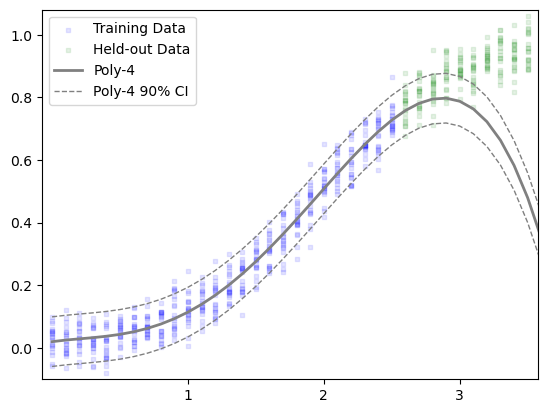

In [14]:
#| label: fig-poly4-eval
#| fig-cap: "POLY-4 Hold-out Evaluation"
plot_predicted_centrality("Poly-4", make_task((0, 2.5), (2.6, 3.5)))

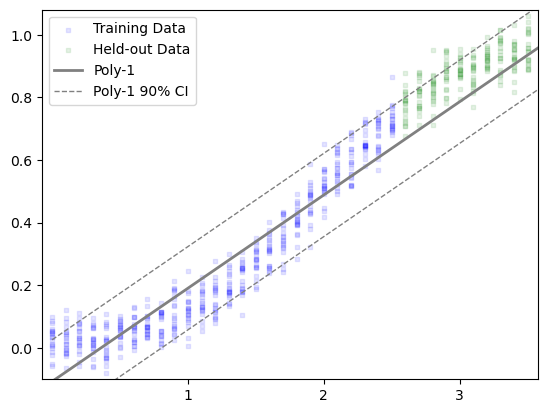

In [15]:
#| label: fig-poly1-eval
#| fig-cap: "POLY-1 Hold-out Evaluation"
plot_predicted_centrality("Poly-1", make_task((0, 2.5), (2.6, 3.5)))

## Alternate Prediction Class

In [16]:
step = 0.1
tasks = []
for i in range(0, 10):
    cal_end = round(3.4 - step * i, 1)
    tasks.append(make_task((0, cal_end), (3.5, 3.5)))
print(len(tasks))
tasks.append(make_task((0, 2.5), (2.6, 3.4)))
pclass = WeightedPredictionClass(tasks)
scores = [pclass.predictive_success(partial(predicted_ll, model_name)) for model_name in sim_models]
scores

10


[np.float64(-2.1386458322914335),
 np.float64(1.2209215151126325),
 np.float64(-21.46668435058918),
 np.float64(-2.831988084630039),
 np.float64(-11.741231148018695)]

In [17]:
[math.exp(ll) for ll in scores]

[0.1178142753356378,
 3.3903105169322107,
 4.754856797504306e-10,
 0.05889564766842201,
 7.95880935336731e-06]

In [18]:
def run_gen_simulation(tasks, models):
    """Runs the simulation and returns the results."""

    results_dict = {}
    for model_name in models:
        results_dict[model_name] = {}
        names = []
        for i, task in enumerate(tasks):
            name = str(i)
            names.append(name)
            results_dict[model_name][name] = {
                "ll_score": predicted_ll(model_name, task)
                #"x": x,  # Store x and y for plotting
                #"y": y,
            }
    display(pd.DataFrame([[model] + [results_dict[model][range_name]["ll_score"] for range_name in names] for model in models]))
    return results_dict

In [19]:
results_gen2 = run_gen_simulation(tasks, sim_models)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Poly-0,-1.118959,-1.227402,-1.365171,-1.533124,-1.713439,-1.959911,-2.281350,-2.649863,-3.139755,-3.765091,-2.771038
1,Poly-1,1.233698,1.191902,1.182461,1.195612,1.190609,1.238881,1.307212,1.347694,1.374178,1.340330,0.827560
2,Poly-2,-0.571892,-2.300498,-4.594007,-7.515809,-14.061439,-20.442990,-26.869498,-38.200259,-48.352409,-59.089634,-14.135093
3,Poly-3,1.489999,1.517216,1.513580,1.503340,0.742634,-0.258117,-0.942742,-5.363093,-10.247458,-17.515067,-3.592161
4,Poly-4,0.866315,0.475567,-1.056968,-5.035622,-3.192154,-5.625011,-17.819549,-17.041277,-27.987432,-48.011620,-4.725792


In [20]:
temp = np.exp(np.mean(np.array([[results_gen2[model][range_name]["ll_score"] for range_name in results_gen2[model]] for model in sim_models]), axis=1))
temp

array([1.17814275e-01, 3.39031052e+00, 4.75485680e-10, 5.88956477e-02,
       7.95880935e-06])

In [21]:
temp/temp[1]

array([3.47502905e-02, 1.00000000e+00, 1.40248416e-10, 1.73717562e-02,
       2.34751635e-06])